## Weird Idea

### Make sure the NVIDIA stuff is enabled

If this command doesn't give a GPU, CUDA isn't working and you should fix that...

In [2]:
!nvidia-smi

Thu May  5 06:25:19 2016       
+------------------------------------------------------+                       
| NVIDIA-SMI 364.19     Driver Version: 364.19         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970M    Off  | 0000:01:00.0     Off |                  N/A |
| N/A   37C    P8     1W /  N/A |     22MiB /  6143MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Setup

This part was largely stolen from the deepdream notebook. It assumes the deepdream stuff has been checked out and saved to ``./deepdream``. It assumes the faster-RCNN stuff has been checked out and saved to ``./py-faster-rcnn``

In [1]:
import os

# 3rd party
import numpy as np

import PIL.Image

from skimage.transform import resize
from skimage.filters import gaussian

# Our own imports
import dream_models
reload(dream_models)
from dream_models import DeepDream, caffe, showarray, savearray, histogram_transfer, PartDream

caffe.set_mode_gpu()
caffe.set_device(0)

### Load the DeepDream model

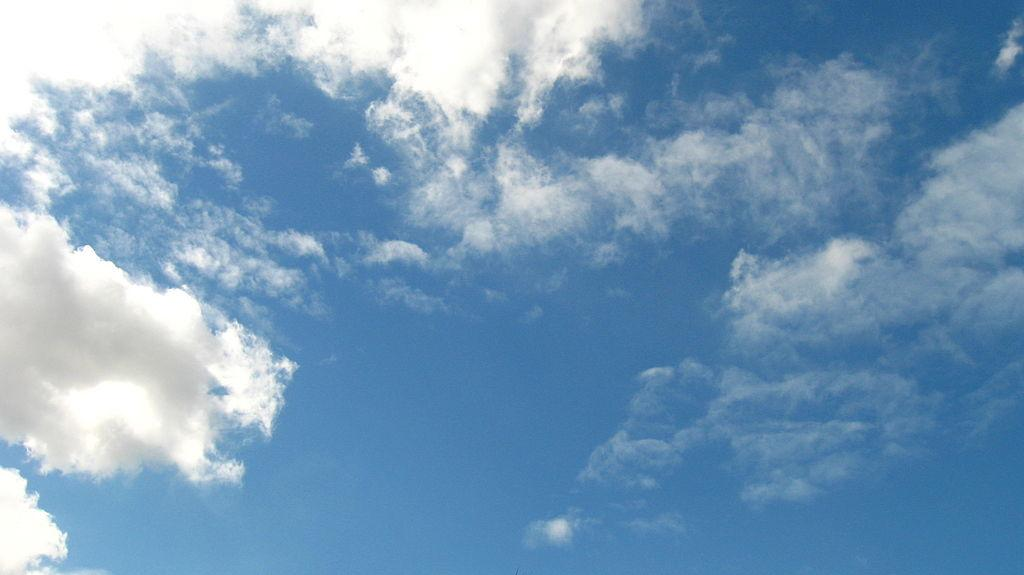

In [3]:
img = np.float32(PIL.Image.open('deepdream/sky1024px.jpg'))
showarray(img)

In [4]:
dream_net = DeepDream('deepdream/models/bvlc_googlenet')
dream_net.load()

In [5]:
dream_net.dream_layers

['inception_3a/output',
 'inception_3b/output',
 'inception_4a/output',
 'inception_4b/output',
 'inception_4c/output',
 'inception_4d/output',
 'inception_4e/output',
 'inception_5a/output',
 'inception_5b/output']

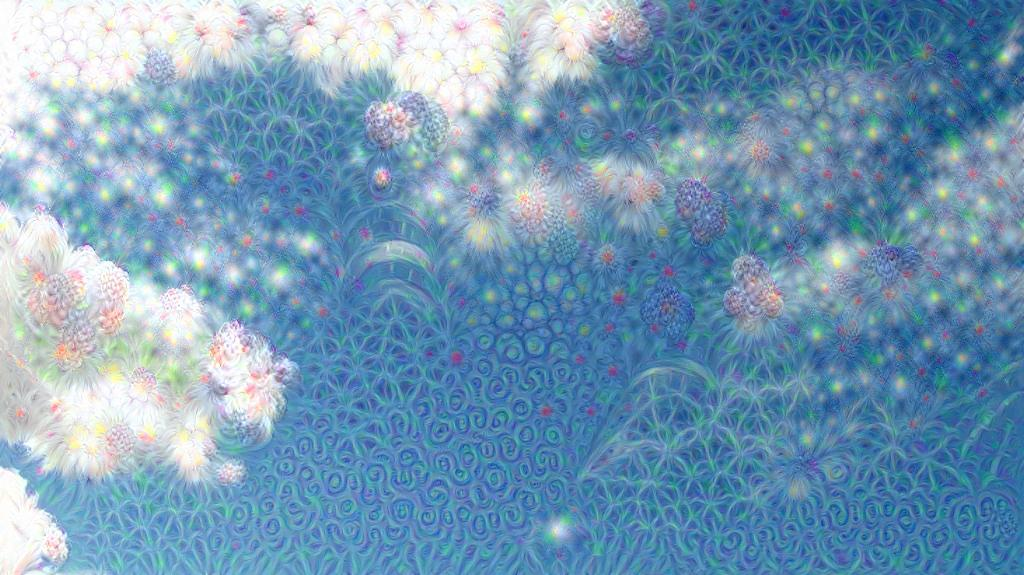

3 9 inception_3b/output (575, 1024, 3)


In [6]:
dream_net.end = 'inception_3b/output'
dream_net.set_guide('deepdream/flowers.jpg')
_=dream_net.deepdream(img)

### Testing rcnn

In [ ]:
!chmod +x ./make_rcnn.sh
!./make_rcnn.sh

In [3]:
!python2 ./py-faster-rcnn/tools/demo.py

I0503 14:26:18.965593  4250 net.cpp:49] Initializing net from parameters: 
name: "VGG_ILSVRC_16_layers"
input: "data"
input: "im_info"
state {
  phase: TEST
}
input_shape {
  dim: 1
  dim: 3
  dim: 224
  dim: 224
}
input_shape {
  dim: 1
  dim: 3
}
layer {
  name: "conv1_1"
  type: "Convolution"
  bottom: "data"
  top: "conv1_1"
  convolution_param {
    num_output: 64
    pad: 1
    kernel_size: 3
  }
}
layer {
  name: "relu1_1"
  type: "ReLU"
  bottom: "conv1_1"
  top: "conv1_1"
}
layer {
  name: "conv1_2"
  type: "Convolution"
  bottom: "conv1_1"
  top: "conv1_2"
  convolution_param {
    num_output: 64
    pad: 1
    kernel_size: 3
  }
}
layer {
  name: "relu1_2"
  type: "ReLU"
  bottom: "conv1_2"
  top: "conv1_2"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1_2"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2_1"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2_1"
  convolution_param {
    num_output: 1

### Sort the validation set for ImageNEt

In [4]:
reload(dream_models)
from dream_models import sort_validation

rootdir = '/home/david/Desktop/CompVis/Project'
infile = os.path.join(rootdir, 'devkit-1.0/data/ILSVRC2010_validation_ground_truth.txt')
indir = os.path.join(rootdir, 'images/val')
codefile = os.path.join(rootdir, 'devkit-1.0/data/meta.mat')

sort_validation(indir, infile, codefile)

ImportError: cannot import name sort_validation

### Demos

In [11]:
dream_net = DeepDream()
dream_net.load()

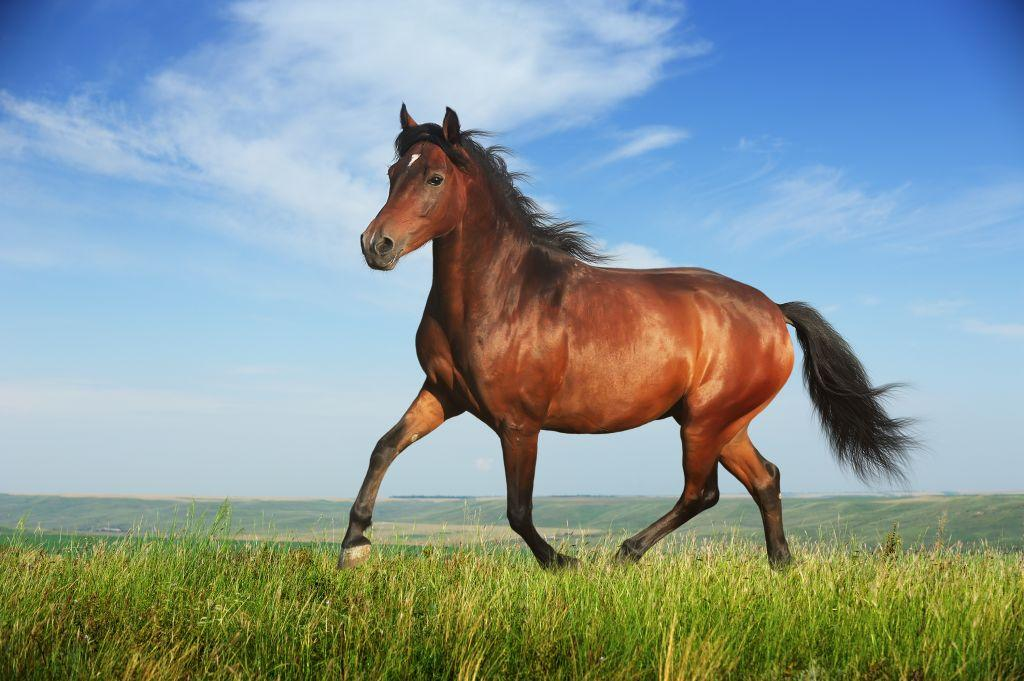

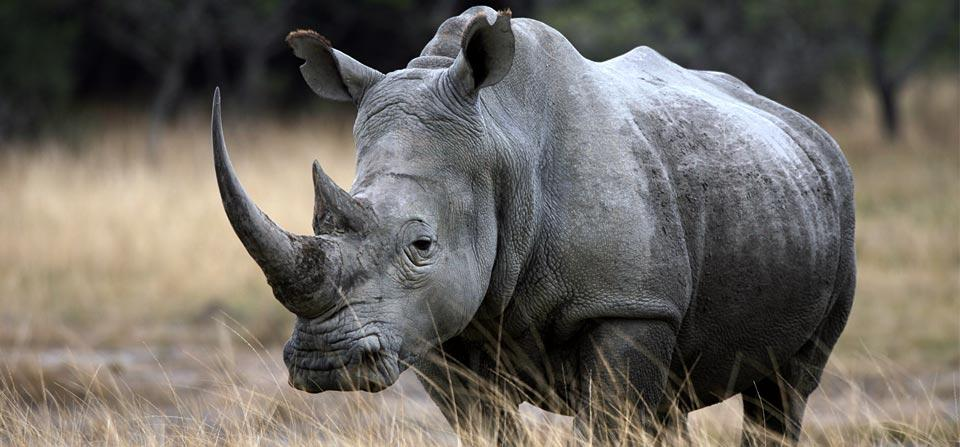

In [61]:
baseimg_fn = os.path.join('examples', 'horse.jpg')
baseimg = np.float32(PIL.Image.open(baseimg_fn))
showarray(baseimg)

guideimg_fn = os.path.join('examples', 'rhino.jpg')
guideimg = np.float32(PIL.Image.open(guideimg_fn))
showarray(guideimg)

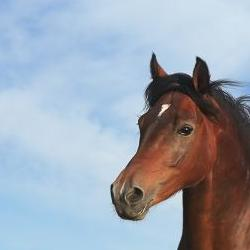

In [62]:
bx0, bx1 = 50, 300
by0, by1 = 250, 500

showarray(baseimg[bx0:bx1, by0:by1])


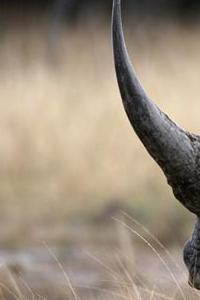

In [84]:
gx0, gx1 = 100, 400
gy0, gy1 = 100, 300

gimg = guideimg[gx0:gx1, gy0:gy1]

showarray(gimg)
savearray(gimg, 'guide_temp.jpg')

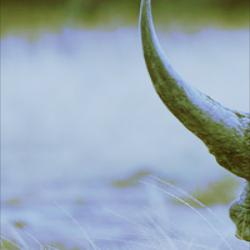

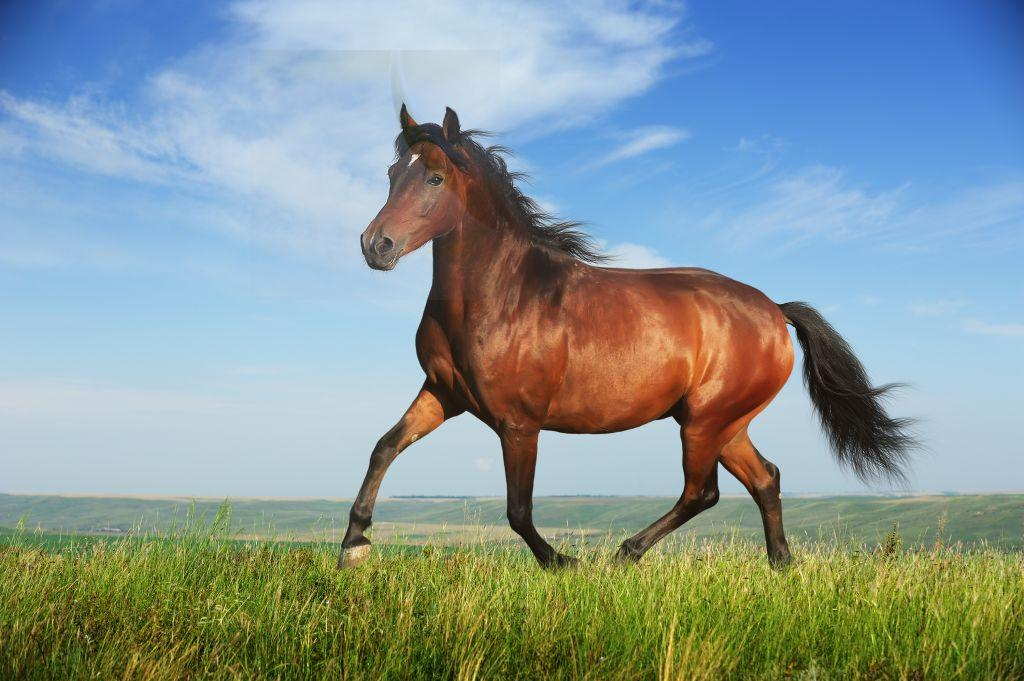

In [88]:
reload(dream_models)
from dream_models import histogram_transfer
weight = 0.3
sigma = 64

img = baseimg.copy()
gimg = histogram_transfer(baseimg, guideimg)
rimg = resize(gimg[gx0:gx1, gy0:gy1]/255.0, (bx1-bx0, by1-by0))*255

showarray(rimg)

maskimg = np.zeros_like(img)
maskimg[bx0+sigma//2:bx1-sigma//2, by0+sigma//2:by1-sigma//2] = 1.0
maskimg = gaussian(maskimg, sigma, multichannel=True)

bimg = rimg * weight + baseimg[bx0:bx1, by0:by1] * (1-weight)
mimg = maskimg[bx0:bx1, by0:by1]
img[bx0:bx1, by0:by1] = mimg * bimg + baseimg[bx0:bx1, by0:by1] * (1-mimg)
showarray(img)

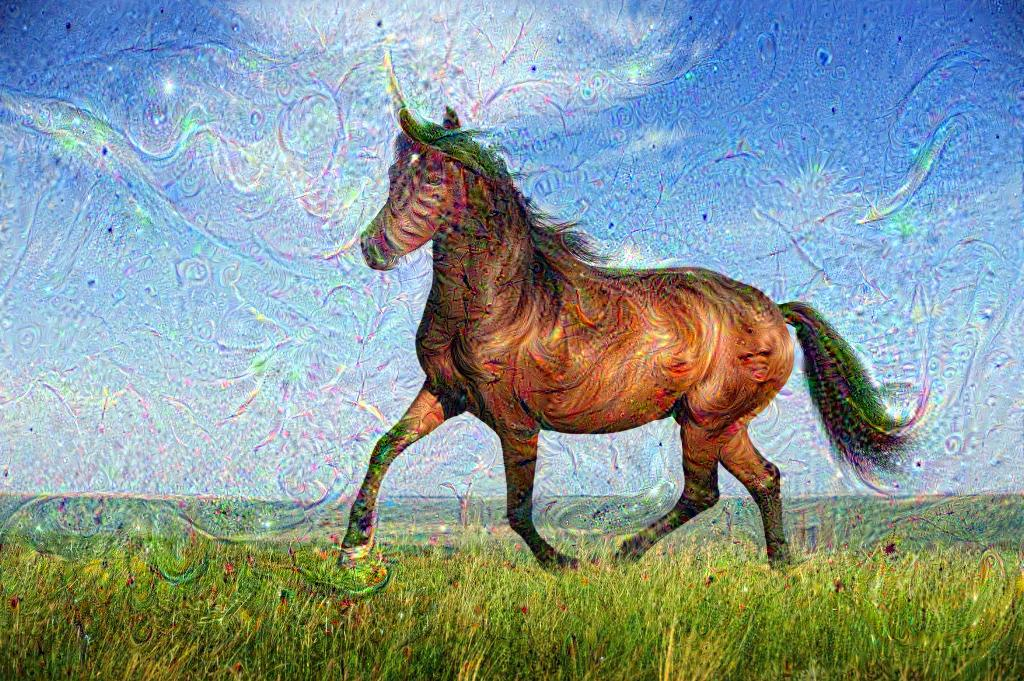

3 9 inception_5b/output (681, 1024, 3)


In [89]:
dream_net.end = 'inception_5b/output'
dream_net.set_guide('guide_temp.jpg')

for _ in range(3):
    img = dream_net.deepdream(img, iter_n=10, octave_n=4)

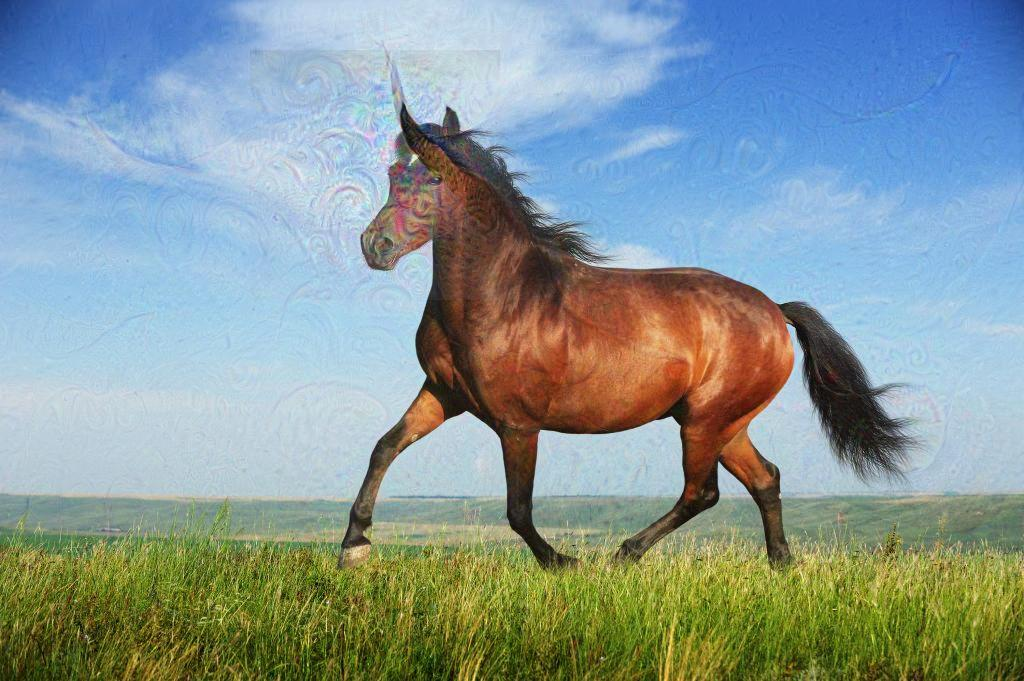

In [2]:
reload(dream_models)
from dream_models import PartDream, DeepDream

base_roi = 50, 300, 250, 500
guide_roi = 100, 400, 100, 300

dream_net = DeepDream()
dream_net.load()

part_dream = PartDream(dream_net, weight=0.4)
part_dream.set_base('examples/horse.jpg')
part_dream.add_part('examples/rhino.jpg', base_roi, guide_roi)
finalimg = part_dream.dream()
showarray(finalimg)

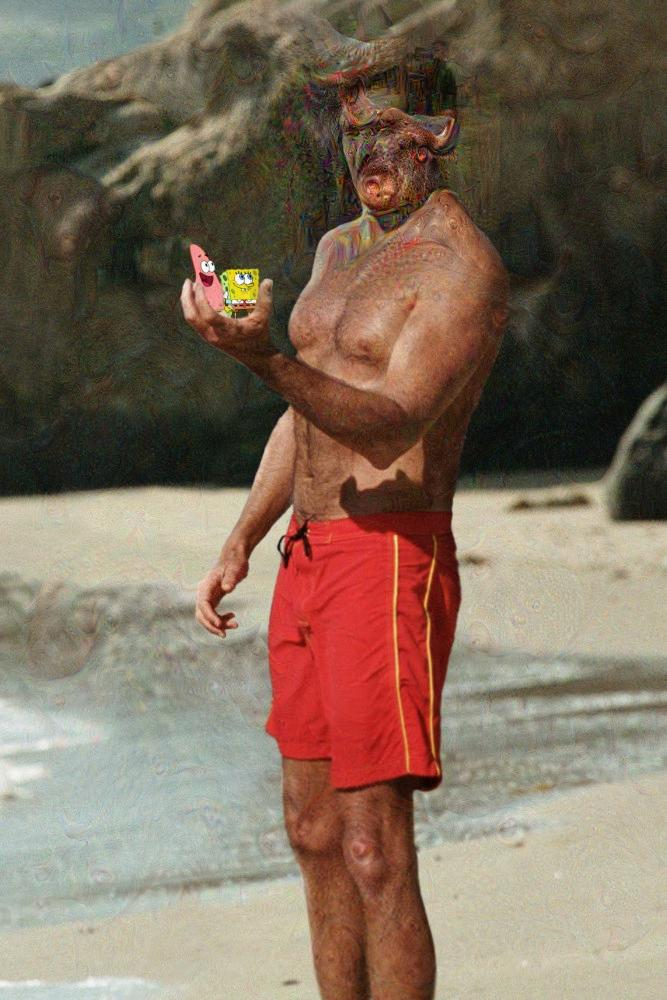

In [3]:
reload(dream_models)
from dream_models import PartDream, DeepDream

base_roi = 0, 300, 250, 500
guide_roi = 100, 500, 250, 500

dream_net = DeepDream()
dream_net.load()

part_dream = PartDream(dream_net, weight=0.6)
part_dream.set_base('examples/hoff.jpg')
part_dream.add_part('examples/bull.jpg', base_roi, guide_roi)
finalimg = part_dream.dream()
showarray(finalimg)

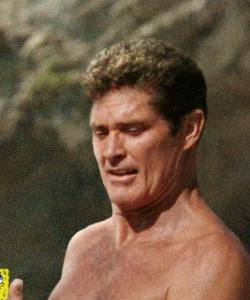

In [16]:
bx0, bx1 = 0, 300
by0, by1 = 250, 500

showarray(baseimg[bx0:bx1, by0:by1])

In [5]:
gx0, gx1 = 100, 500
gy0, gy1 = 250, 530

gimg = guideimg[gx0:gx1, gy0:gy1]

showarray(gimg)
savearray(gimg, 'guide_temp.jpg')

NameError: name 'guideimg' is not defined

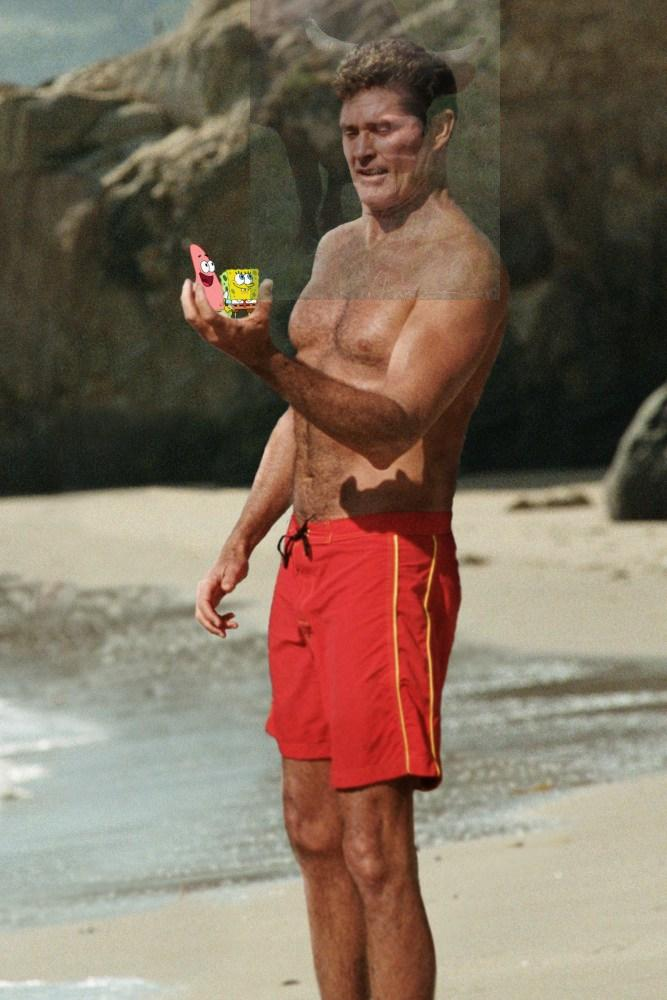

In [18]:
weight = 0.3

img = baseimg.copy()
maskimg = np.zeros_like(img)
maskimg[bx0:bx1, by0:by1] = 1.0
maskimg = gaussian(maskimg, 32, multichannel=True)

rimg = resize(guideimg[gx0:gx1, gy0:gy1]/255.0, (bx1-bx0, by1-by0))*255
# rimg = histogram_transfer(baseimg[bx0:bx1, by0:by1], rimg)

img[bx0:bx1, by0:by1] = rimg * weight + baseimg[bx0:bx1, by0:by1] * (1-weight)
showarray(img)

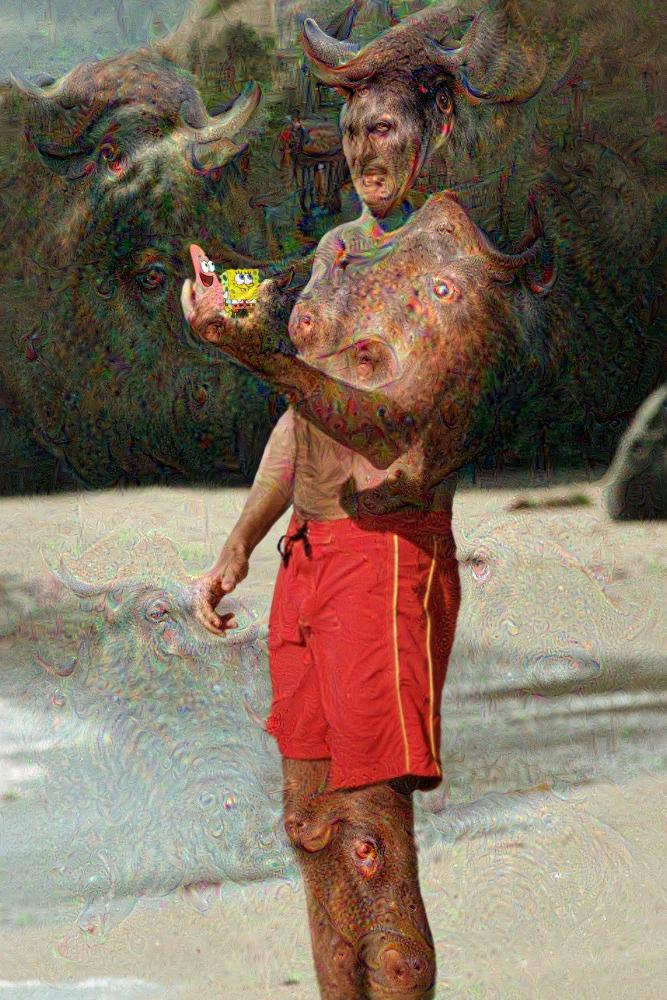

3 9 inception_5b/output (1000, 667, 3)


In [19]:
dream_net.end = 'inception_5b/output'
dream_net.set_guide('guide_temp.jpg')

for _ in range(3):
    newimg = dream_net.deepdream(img.copy(), iter_n=10, octave_n=4)
    img = newimg * maskimg + (1-maskimg)*baseimg
showarray(img)